# Hadoop 

In [1]:
import pandas as pd
import altair as alt
import re
path = "combined.log"
data = []
with open(path) as f:
    f = f.readlines()
    for line in f:
       new_line = line.split()
       if len(new_line)>3:
         if new_line[2]=="INFO" or new_line[2]=="WARN" or new_line[2]=="ERROR":
            date = new_line[0]
            hour = new_line[1]
            label = new_line[2]
            bracketsInfo= line[line.find('[')+len('['):line.find(']')]
            func = ""
            m = line.split(".hadoop.",1)
            if len(m)>1:
              func = m[1].split(".",1)[0]
            
            hasError = False
            hasException =False
            message = []
            for i in range(3,len(new_line)):
              if "Error" in new_line[i]:
                hasError = True
              if "Exception" in new_line[i]:
                hasException = True
              message.append(new_line[i])
            data.append([date,hour,label,bracketsInfo,hasError,hasException,func,message])


df = pd.DataFrame(data, columns=['date', 'hour', 'label','bracketsInfo','hasError','hasException','func','message'])


In [2]:
df.head(5)

,date,hour,label,bracketsInfo,hasError,hasException,func,message
0,2015-10-17,"15:37:56,547",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
1,2015-10-17,"15:37:56,899",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
2,2015-10-17,"15:37:56,900",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
3,2015-10-17,"15:37:57,036",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
4,2015-10-17,"15:37:57,634",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."


In [3]:
len(df)

127019

In [4]:
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook 
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [5]:
df_exp = df.explode('func').explode('hasException')

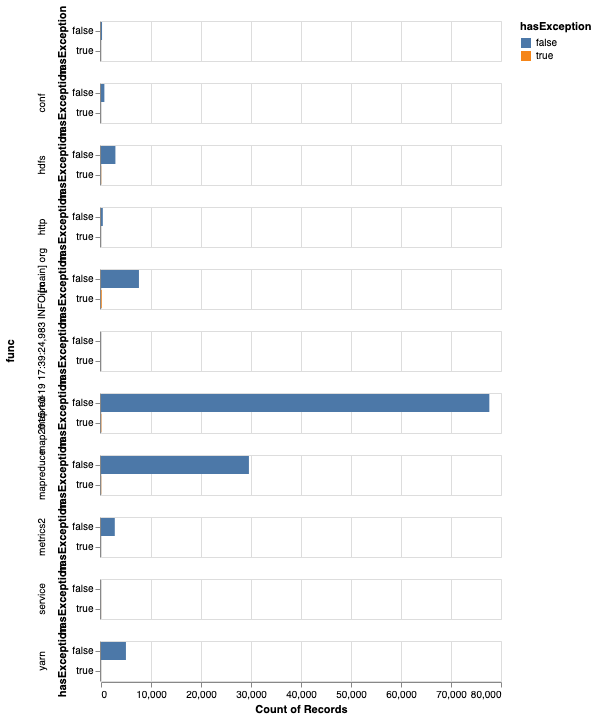

In [6]:
alt.Chart(df_exp).mark_bar().encode(
    x='count()',
y='hasException',
    color='hasException'
).facet(
    row='func'
)